In [24]:
import re
import json
import random
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# to split text into sentences
from nltk.tokenize import sent_tokenize

# for model fine-tuning
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# LUKE model
from transformers import LukeTokenizer, LukeForEntitySpanClassification, \
    DataCollatorWithPadding, AdamW, get_scheduler

# spaCy model
import spacy
from spacy.tokens import DocBin
from spacy.util import filter_spans
from spacy import displacy

plt.style.use('seaborn-v0_8')

In [25]:
path_to_data = '../benchmark_data/'
path_to_models = 'models/'
path_to_results = 'results/'
path_to_plots = 'plots/'

# NER, Data

In [26]:
results = pd.DataFrame(columns=['model_name', 'macro_precision', 'macro_recall', 'macro_f1', 'p_PER', 'p_ORG', 'r_PER', 'r_ORG', 'f1_PER', 'f1_ORG'])

In [27]:
# transform from json to pd.DataFrame

def split_text_into_sentences(row):
    """Splits each instance into multiple sentences with corresponding entities."""

    # split text into sentences
    sentences = sent_tokenize(row['text'])
    entities = row['entities']
    entity_spans = row['entity_spans']
    labels = row['labels']
    
    new_rows = []
    # for each sentence find entities with adjusted spans
    for sentence in sentences:

        sentence_start_index = row['text'].find(sentence)
        sentence_end_index = sentence_start_index + len(sentence)

        sentence_entities = []
        sentence_entity_spans = []
        sentence_labels = []
        
        # filter entities, entity_spans, and labels for the current sentence
        for entity, span, label in zip(entities, entity_spans, labels):
            if span[0] >= sentence_start_index and span[1] <= sentence_end_index:
                adjusted_span = (span[0] - sentence_start_index, span[1] - sentence_start_index)

                sentence_entities.append(entity)
                sentence_entity_spans.append(adjusted_span)
                sentence_labels.append(label)
        
        # if sentence has entities add it to the dataset
        if len(sentence_entities) != 0:
            new_row = {
                'text': sentence,
                'entities': sentence_entities,
                'entity_spans': sentence_entity_spans,
                'labels': sentence_labels
            }
            
            new_rows.append(new_row)
    
    return pd.DataFrame(new_rows)

def transform_json_ner(path):
    """
    Transforms json into pd.DataFrame.
    Args:
        path : string that contains path to the json file
    """

    with open(path) as f:
        data = json.load(f)

    texts = []
    entities = []
    entity_spans = []
    labels = []

    for item in data:

        item_entities = []
        item_entity_spans = []
        item_labels = []

        text = item['data']['text']
        annotations = item['annotations'][0]['result']

        for annotation in annotations:

            # get only entities out of the annotations dataset
            if annotation['type'] == 'labels':

                entity_span = (annotation['value']['start'], annotation['value']['end'])
                entity = annotation['value']['text']
                label = annotation['value']['labels'][0]

                
                item_entities.append(entity)
                item_entity_spans.append(entity_span)
                item_labels.append(label)

        texts.append(text)
        entities.append(item_entities)
        entity_spans.append(item_entity_spans)
        labels.append(item_labels)


    df = pd.DataFrame({'text': texts, 'entities': entities, 'entity_spans': entity_spans, 'labels': labels})
    df = pd.concat([split_text_into_sentences(row) for _, row in df.iterrows()], ignore_index=True)

    return df

In [28]:
df_ner = transform_json_ner(path_to_data + 'annotations.json')
train_split = pd.read_csv(path_to_data + 'train_test_split/train.csv')
test_split = pd.read_csv(path_to_data + 'train_test_split/test.csv')

# select senteces for train and test dataframes
train_df = pd.merge(df_ner, train_split, how='inner', on='text')
test_df = pd.merge(df_ner, test_split, how='inner', on='text')

df_ner


,text,entities,entity_spans,labels
0,"Zelensky is Pinocchio, officer tells The New Y...","[Zelensky, The New Yorker]","[(0, 8), (37, 51)]","[PER, ORG]"
1,A Ukrainian officer interviewed by The New Yor...,"[The New Yorker, Vladimir Zelensky, RT.com]","[(35, 49), (73, 90), (156, 162)]","[ORG, PER, ORG]"
2,SmartBear Names SVP of Growth Marketing to Sca...,[SmartBear],"[(0, 9)]",[ORG]
3,Kevin Foster brings 25+ years of marketing exp...,"[Kevin Foster, SmartBear, SmartBear, Kevin Fos...","[(0, 12), (89, 98), (99, 108), (192, 204)]","[PER, ORG, ORG, PER]"
4,Kevin comes to SmartBear from the startup High...,"[Kevin, SmartBear, Highway.ai]","[(0, 5), (15, 24), (42, 52)]","[PER, ORG, ORG]"
...,...,...,...,...
575,Top End Energy Advances Low-Carbon Vision.,[Top End Energy],"[(0, 14)]",[ORG]
576,Top End Energy Limited (AU:TEE) has released a...,[Top End Energy Limited],"[(0, 22)]",[ORG]
577,"Top End Energy Limited, an Australian energy c...",[Top End Energy Limited],"[(0, 22)]",[ORG]
578,Azelis Expands Its Portfolio in Germany With t...,"[Azelis, DBH Osthandelsgesellschaft mbH]","[(0, 6), (102, 132)]","[ORG, ORG]"


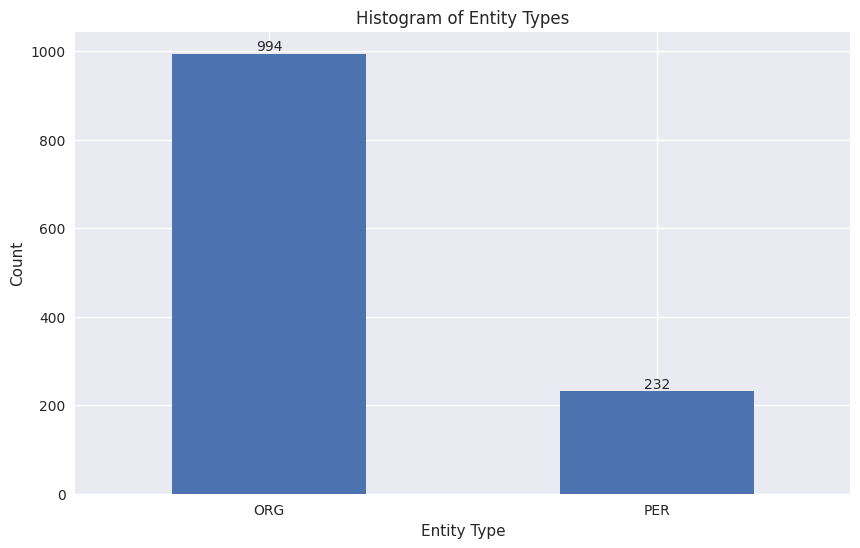

In [29]:
# plot the class distribution in the data set

all_labels = [label for sublist in df_ner['labels'] for label in sublist]

plt.figure(figsize=(10, 6))
value_counts = pd.Series(all_labels).value_counts()
ax = value_counts.plot(kind='bar')

for i in ax.containers:
    ax.bar_label(i, label_type='edge')

plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.title('Histogram of Entity Types')
plt.xticks(rotation=0)
plt.savefig(path_to_plots + 'benchmark_for_ner.png')
plt.show()

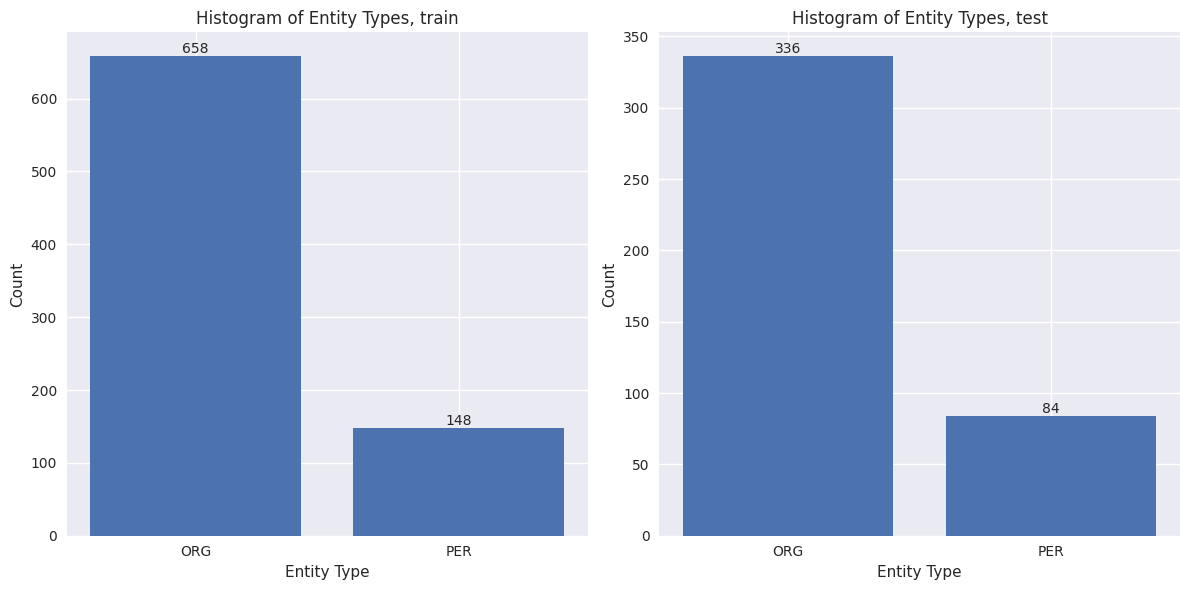

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

all_labels_train = [label for sublist in train_df['labels'] for label in sublist]
train_value_counts = pd.Series(all_labels_train).value_counts()
ax1.bar(train_value_counts.index, train_value_counts.values)

for i in ax1.patches:
    ax1.text(i.get_x() + i.get_width() / 2, i.get_height(), str(i.get_height()), ha='center', va='bottom')

ax1.set_xlabel('Entity Type')
ax1.set_ylabel('Count')
ax1.set_title('Histogram of Entity Types, train')
ax1.tick_params(axis='x', rotation=0) 


all_labels_test = [label for sublist in test_df['labels'] for label in sublist]
test_value_counts = pd.Series(all_labels_test).value_counts()
ax2.bar(test_value_counts.index, test_value_counts.values)

for i in ax2.patches:
    ax2.text(i.get_x() + i.get_width() / 2, i.get_height(), str(i.get_height()), ha='center', va='bottom')

ax2.set_xlabel('Entity Type')
ax2.set_ylabel('Count')
ax2.set_title('Histogram of Entity Types, test')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig(path_to_plots + 'ner_test_train.png')

plt.show()


# NER, LUKE

In [31]:
# models' names
model_name_luke_base = "studio-ousia/luke-base"
model_name_nk_finetuned = "nk_LUKE_ner"
model_name_conll_2003 = "studio-ousia/luke-large-finetuned-conll-2003"

task_entity_span = "entity_span_classification"

# NIL - No Information Label
id2label = {0: 'NIL', 1: 'PER', 2: 'ORG'}
label2id = {v:k for k,v in id2label.items()}

# models
model_luke_base = LukeForEntitySpanClassification.from_pretrained(model_name_luke_base, num_labels=len(label2id), id2label=id2label, label2id=label2id)
model_conll_2003 = LukeForEntitySpanClassification.from_pretrained(model_name_conll_2003)

# tokenizer
tokenizer_luke_base = LukeTokenizer.from_pretrained(model_name_luke_base, task=task_entity_span)
tokenizer_conll_2003 = LukeTokenizer.from_pretrained(model_name_conll_2003, task=task_entity_span)

# parameters for fine-tuning
train_batch = 4
test_batch = 2
epochs = 4
lr=5e-5

Some weights of LukeForEntitySpanClassification were not initialized from the model checkpoint at studio-ousia/luke-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at studio-ousia/luke-large-finetuned-conll-2003 were not used when initializing LukeForEntitySpanClassification: ['luke.embeddings.position_ids']
- This IS expected if you are initializing LukeForEntitySpanClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LukeForEntitySpanClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have 

In [32]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_luke_base.to(device)
device

device(type='cpu')

## 2. NER, LUKE: DataSet, tokenizer 

In [33]:
class CustomDataCollatorWithPadding(DataCollatorWithPadding):
    """Custom DataCollatorWithPadding to pad labels as well"""

    def __call__(self, features):
        batch = {}
        for key in features[0].keys():
            try:
                if key != "labels":
                    batch[key] = pad_sequence([feature[key] for feature in features], batch_first=True, padding_value=self.tokenizer.pad_token_id)
                else:
                    # padd labels list with 0 - NIL label
                    batch[key] = pad_sequence([feature[key] for feature in features], batch_first=True, padding_value=0)
            except:
                print(features)

        return batch


class NERDataset(Dataset):
    """Named entitry recognition dataset"""

    word_start_pattern = re.compile(r'\b\w')
    word_end_pattern = re.compile(r'\w\b')

    def __init__(self, data, tokenizer):
        """
        Args:
            data : Pandas dataframe.
            tokenizer : tokenizer to encode data.
        """
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        item = self.data.iloc[idx]

        text = item.text
        entity_spans = item.entity_spans
        entities = item.entities
        labels = item.labels

        model_entity_spans = self.return_entity_span(idx)
        model_labels = []

        # encode text, entity_spans
        # we use only truncation, as we will perform padding for each batch
        # max_entiry_lenght is number of entity spans we have generated. So, we pass to the models each entiry we have generated
        encoding = self.tokenizer(text, entity_spans=model_entity_spans, truncation=True, return_tensors="pt", max_entity_length=len(model_entity_spans))

        for k,v in encoding.items():
          encoding[k] = encoding[k].squeeze()
           
        # in case the input is only one word we need to add dimention to tensors
        if list(encoding['entity_ids'].size()) == []:
            encoding['entity_ids'] = encoding['entity_ids'].unsqueeze(0)
            encoding['entity_position_ids'] = encoding['entity_position_ids'].unsqueeze(0)
            encoding['entity_start_positions'] = encoding['entity_start_positions'].unsqueeze(0)
            encoding['entity_end_positions'] = encoding['entity_end_positions'].unsqueeze(0)
            encoding['entity_attention_mask'] = encoding['entity_attention_mask'].unsqueeze(0)

        # create label variable torch.tensor(batch_size, entity_length), where 'max_entity_length' can be changed.
        # the label variable contains labels for each entity span we have generated.
        # for single-label classification - one label per instance.
        
        model_labels = [0] * len(encoding['entity_start_positions'])

        for i, model_tuple in enumerate(model_entity_spans): 
            
            if model_tuple in entity_spans:

                index = entity_spans.index(model_tuple)
                l = labels[index]

                model_labels[i] = label2id[l]

        encoding["labels"] = torch.tensor(model_labels)

        return encoding
    
    def return_entity_span(self, idx):

        item = self.data.iloc[idx]

        text = item.text
        entity_spans = item.entity_spans

        model_entity_spans = []

        # word start and end positions to calculate spans 
        word_start_positions = [match.start() for match in NERDataset.word_start_pattern.finditer(text)]
        word_end_positions = [match.end() for match in NERDataset.word_end_pattern.finditer(text)] 

        # all possible entity spans
        # we consider only entity spans that are not longer then 6 words
        for i, start_pos in enumerate(word_start_positions):
            for end_pos in word_end_positions[i:i+6]:
                model_entity_spans.append((start_pos, end_pos))

        # in case not all required entities are detedted, add entity spans from dataset
        model_entity_spans = list(set(model_entity_spans).union(set(entity_spans)))

        model_entity_spans.sort(key=lambda x: x[0])

        return model_entity_spans
    
    def return_item(self, idx):

        item = self.data.iloc[idx]

        text = item.text
        entity_spans = item.entity_spans
        entities = item.entities
        labels = item.labels

        return text, entity_spans, entities, labels
    
def return_datasets_luke(test_df, train_df, tokenizer):
    test_dataset = NERDataset(test_df, tokenizer)
    train_dataset = NERDataset(train_df, tokenizer)

    return test_dataset, train_dataset


def return_dataloader_luke(test_df, train_df, tokenizer):
    # use DataCollator to implement padding for the batch ranther than the full dataset
    data_collator = CustomDataCollatorWithPadding(tokenizer)

    test_dataset, train_dataset = return_datasets_luke(test_df, train_df, tokenizer)

    # suffle = Ture, suffle at the end of each epoch
    test_dataloader = DataLoader(test_dataset, batch_size=test_batch, collate_fn=data_collator)
    train_dataloader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, collate_fn=data_collator)

    return test_dataloader, train_dataloader

In [34]:
test_finetune_dataset, train_finetune_dataset = return_datasets_luke(test_df, train_df, tokenizer_luke_base)
test_finetune_dataloader, train_finetune_dataloader = return_dataloader_luke(test_df, train_df, tokenizer_luke_base)

test_conll_2003_dataset, train_conll_2003_dataset = return_datasets_luke(test_df, train_df, tokenizer_conll_2003)
test_conll_2003_dataloader, train_conll_2003_dataloader = return_dataloader_luke(test_df, train_df, tokenizer_conll_2003)

## 3. NER, LUKE: test batch before fine-tuning

In [35]:
for batch in train_finetune_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([4, 97]),
 'entity_ids': torch.Size([4, 304]),
 'entity_position_ids': torch.Size([4, 304, 30]),
 'entity_start_positions': torch.Size([4, 304]),
 'entity_end_positions': torch.Size([4, 304]),
 'attention_mask': torch.Size([4, 97]),
 'entity_attention_mask': torch.Size([4, 304]),
 'labels': torch.Size([4, 304])}

In [36]:
tokenizer_luke_base.decode(batch['input_ids'][0])

'<s>LI-COR Environmental Acquires Onset.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [37]:
batch['labels'][0]

tensor([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [38]:
outputs = model_luke_base(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(0.9050, grad_fn=<NllLossBackward0>) torch.Size([4, 304, 3])


In [39]:
outputs.logits[0].argmax(-1).squeeze()

tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## 4. NER, LUKE: model fine-tuning

In [17]:
# define the training function
def train_model(model, dataloader, epochs=epochs, learning_rate=lr):
    model.train()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    num_training_steps = epochs * len(dataloader)
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )

    for epoch in range(epochs):
        for batch in tqdm(dataloader):
            optimizer.zero_grad()
            
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            loss = outputs.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

        print(f"Epoch {epoch+1} completed with loss: {loss.item()}")

In [18]:
# Train the model
train_model(model_luke_base, train_finetune_dataloader)

/home/devuser1/miniconda3/envs/python3_11/lib/python3.11/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 95/95 [07:42<00:00,  4.87s/it]


Epoch 1 completed with loss: 0.02919020690023899


100%|██████████| 95/95 [07:37<00:00,  4.82s/it]


Epoch 2 completed with loss: 0.026501700282096863


100%|██████████| 95/95 [07:27<00:00,  4.71s/it]


Epoch 3 completed with loss: 0.030348408967256546


100%|██████████| 95/95 [07:49<00:00,  4.94s/it]

Epoch 4 completed with loss: 0.016998687759041786


In [19]:
model_luke_base.save_pretrained(path_to_models + model_name_nk_finetuned)

## 5. NER, LUKE: Evaluation

In [40]:
# function to evaluate the luke model
def evaluate_luke_model(model, name, dataloader):
    model.eval()
    labels = []
    preds = []

    class_labels = [1, 2]

    TP = {1:0, 2:0}
    FP = {1:0, 2:0}
    FN = {1:0, 2:0}

    precisions = []
    recalls = []
    f1_scores = []

    with torch.no_grad():
        for batch in tqdm(dataloader):

            batch_labels = batch["labels"]

            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=-1)

            labels.extend(batch_labels.numpy().tolist())
            preds.extend(batch_preds.numpy().tolist())

    true_labels = [item for sublist in labels for item in sublist]
    
    if len(model.config.id2label) > 3:
        # adjust labels of the luke-large-finetuned-conll-2003 model
        pred_labels = [item - 1 if model.config.id2label[item] in ['ORG', 'PER'] else 0 for sublist in preds for item in sublist]
    else:
        pred_labels = [item for sublist in preds for item in sublist]
        
    for t, p in zip(true_labels, pred_labels):
        if t == p: 
            if t == 0: # if entity is 'NIL' skip
                continue
            elif t in class_labels: # entity type is correctly recognized by NER
                TP[p] = TP[p] + 1
        else:
            if t == 0: # 'NIL' entity is classified, false positive for the predicted class
                FP[p] = FP[p] + 1
            elif p == 0: # false negative for the true class, as entity was not recognized
                FN[t] = FN[t] + 1
            else: # wrong entity type, flase negative for true class, false positive for predicted class
                FP[p] = FP[p] + 1
                FN[t] = FN[t] + 1

    try:
        for class_ in class_labels:
            precision_class = TP[class_] / (TP[class_] + FP[class_])
            recall_class = TP[class_] / (TP[class_] + FN[class_])

            precisions.append(precision_class)
            recalls.append(recall_class)
            f1_scores.append(2 * precision_class * recall_class / (precision_class + recall_class))

        macro_precision = sum(precisions) / len(class_labels)
        macro_recall = sum(recalls) / len(class_labels)
        macro_f1 = sum(f1_scores) / len(class_labels)

        print(name)
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print(f"Precision macro: {macro_precision}")
        print(f"Recall macro: {macro_recall}")
        print(f"F1 Score macro: {macro_f1}")
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    except ZeroDivisionError as e:
        print(e)
        macro_precision, macro_recall, macro_f1 = 0, 0, 0

    return [name, macro_precision, macro_recall, macro_f1] + precisions + recalls + f1_scores


In [41]:
model_nk_finetuned = LukeForEntitySpanClassification.from_pretrained(path_to_models+ model_name_nk_finetuned)

# evaluate the model
model_nk_finetuned_results = evaluate_luke_model(model_nk_finetuned, model_name_nk_finetuned, test_finetune_dataloader)

100%|██████████| 101/101 [00:34<00:00,  2.93it/s]

nk_LUKE_ner
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Precision macro: 0.7193387051958877
Recall macro: 0.5729166666666667
F1 Score macro: 0.6352508645800378
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [42]:
model_conll_2003_results = evaluate_luke_model(model_conll_2003, 'luke-large-finetuned-conll-2003', test_conll_2003_dataloader)

100%|██████████| 101/101 [01:50<00:00,  1.09s/it]

luke-large-finetuned-conll-2003
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Precision macro: 0.7319252220615575
Recall macro: 0.8541666666666667
F1 Score macro: 0.7879288589797513
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [43]:
results.loc[len(results)] = model_nk_finetuned_results
results.loc[len(results)] = model_conll_2003_results
results

,model_name,macro_precision,macro_recall,macro_f1,p_PER,p_ORG,r_PER,r_ORG,f1_PER,f1_ORG
0,nk_LUKE_ner,0.719339,0.572917,0.635251,0.779661,0.659016,0.547619,0.598214,0.643357,0.627145
1,luke-large-finetuned-conll-2003,0.731925,0.854167,0.787929,0.808511,0.655340,0.904762,0.803571,0.853933,0.721925


## 6. NER, LUKE: Inference

In [44]:
def inference(model, tokenizer, number_of_items, dataset, seed=42):

    np.random.seed(seed)

    l = len(dataset.data)
    indx = random.sample(range(l), number_of_items)

    for i in indx:
            text, entity_spans, entities, labels = dataset.return_item(i)
            model_entity_spans = dataset.return_entity_span(i)

            inputs = tokenizer(text, entity_spans=model_entity_spans, max_entity_length=len(model_entity_spans), return_tensors="pt")
            outputs = model(**inputs)

            logits = outputs.logits
            
            print("Sentence:", text)
            ground_truth = ''
            for span, label in zip(entity_spans, labels):
                 ground_truth += text[span[0]:span[1]] + ' ' + label + ', '
            
            print("Ground truth labels: ", ground_truth)

            predicted_class_indices = logits.argmax(-1).squeeze().tolist()
            
            for span, predicted_class_idx in zip(model_entity_spans, predicted_class_indices):
                predicted_label = model.config.id2label[predicted_class_idx]
                if predicted_label in ['ORG', 'PER']:
                    print(f"Entity: {text[span[0]:span[1]]}, Predicted Label: {predicted_label}")

            print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

In [45]:
inference(model_nk_finetuned, tokenizer_luke_base, 5, test_finetune_dataset)

Sentence: Exclusive: Why Ruben Amorim is emerging as the favourite for the Liverpool job, according to expert.
Ground truth labels:  Ruben Amorim PER, Liverpool ORG, 
Entity: Why Ruben Amorim, Predicted Label: PER
Entity: Ruben Amorim, Predicted Label: PER
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Sentence: Switzerland lays out new 'too big to fail' rules in wake of Credit Suisse banking turmoil last year.
Ground truth labels:  Credit Suisse ORG, 
Entity: Credit Suisse, Predicted Label: ORG
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Sentence: Centaur Media is a London-based business consultancy group, with a market capitalisation of GBP81.1 million.
Ground truth labels:  Centaur Media ORG, 
Entity: Centaur Media, Predicted Label: ORG
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Sentence: VYRE Network announces a groundbreaking partnership with Triad Entertainment Network starting with the much-anticipated HBCU Boxing League......
Ground truth labels:  VYRE Network ORG, Triad Entertainment Network ORG, 
Enti

In [46]:
inference(model_conll_2003, tokenizer_conll_2003, 5, test_conll_2003_dataset)

Sentence: The company, called Sealenic, has already partnered with three shipping companies – Reederei F. Laeisz, Fairplay Towage, and Harren Ship Management.
Ground truth labels:  Sealenic ORG, Reederei F. Laeisz ORG, Fairplay Towage ORG, Harren Ship Management ORG, 
Entity: Sealenic, Predicted Label: ORG
Entity: Reederei F. Laeisz, Predicted Label: ORG
Entity: Fairplay Towage, Predicted Label: ORG
Entity: Harren Ship Management, Predicted Label: ORG
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Sentence: Intertronics, a supplier of adhesives, coatings, sealants, and equipment for manufacturing and technology applications, has completed on the purchase of Dyne Testing Ltd, a UK manufacturer and supplier of surface measurement technology.
Ground truth labels:  Intertronics ORG, Dyne Testing Ltd ORG, 
Entity: Intertronics, Predicted Label: ORG
Entity: Dyne Testing Ltd, Predicted Label: ORG
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Sentence: IDIS Americas Makes Industry Debut At ISC West With Comprehens

# NER, spaCy

## 1. NER, spaCy: Data preparation

In [47]:
def convert_df_spacy(df):
    """Coverts dataframe to lits of tuples"""
    result = []

    for row in df.itertuples():
        text = row.text
        entities = []

        for index, entity_span in enumerate(row.entity_spans):
            entities.append((entity_span[0], entity_span[1], row.labels[index]))

        result.append({'text':text, 'entities':entities})

    return result


def convert_to_DocBin(data, path):

    nlp = spacy.blank("en")
    doc_bin = DocBin()

    for training_example in tqdm(data):
        text = training_example['text']
        labels = training_example['entities']
        doc = nlp.make_doc(text)
        ents = []

        for start, end, label in labels:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print("Skipping entity")
            else:
                ents.append(span)
        filtered_ents = filter_spans(ents)
        doc.ents = filtered_ents

        doc_bin.add(doc)

    doc_bin.to_disk( path_to_models + "nk_spaCy_ner/" + path +".spacy")


In [48]:
spacy_train_list = convert_df_spacy(train_df)
spacy_test_list = convert_df_spacy(test_df)

convert_to_DocBin(spacy_train_list, 'train')
convert_to_DocBin(spacy_test_list, 'test')

 58%|█████▊    | 219/379 [00:00<00:00, 2186.46it/s]

Skipping entity


100%|██████████| 379/379 [00:00<00:00, 2274.29it/s]


Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 92%|█████████▏| 185/201 [00:00<00:00, 1845.59it/s]

Skipping entity
Skipping entity


100%|██████████| 201/201 [00:00<00:00, 1831.63it/s]

Skipping entity
Skipping entity


## 2. NER, spaCy: Training

    python3 -m spacy download en_core_web_lg   
    python3 -m spacy init fill-config nk_spaCy_ner/base_config.cfg nk_spaCy_ner/config.cfg  
    python3 -m spacy debug data nk_spaCy_ner/config.cfg  
    python3 -m spacy train nk_spaCy_ner/config.cfg --output nk_spaCy_ner/output --paths.train nk_spaCy_ner/train.spacy  --paths.dev nk_spaCy_ner/test.spacy 

## 2. NER, spaCy: Evaluation

In [49]:

def evaluate_spacy_model(nlp, name, test_data):
    spacy_ner_to_labels = {'PERSON':1, 'PER':1, 'ORG':2}

    class_labels = [1, 2]

    TP = {1:0, 2:0}
    FP = {1:0, 2:0}
    FN = {1:0, 2:0}

    precisions = []
    recalls = []
    f1_scores = []

    for item in tqdm(test_data):
        text = item['text']
        annotations = item['entities']

        doc = nlp(text)

        gold_entities = {(ent[0], ent[1]): label2id[ent[2]] for ent in annotations}
        pred_entities = {
            (ent.start_char, ent.end_char): spacy_ner_to_labels[ent.label_]
            for ent in doc.ents if ent.label_ in ['PERSON', 'PER', 'ORG']
        }

        # calculate metrix for 'ORG' and 'PER' true labels
        for gold_start_end, gold_label in gold_entities.items(): 
            if gold_start_end not in pred_entities: # calculate false negatives for undetected entities
                FN[gold_label] = FN[gold_label] + 1
            elif gold_start_end in pred_entities:
                if gold_label == pred_entities[gold_start_end]: # true positive, as predicted class matches the truth
                    TP[gold_label] = TP[gold_label] + 1
                else: # calculate flase neganives and false positives
                    FP[pred_entities[gold_start_end]] = FP[pred_entities[gold_start_end]] + 1
                    FN[gold_label] = FN[gold_label] + 1

        # calculate false positives for wrongly classified enties
        for start_end, label in pred_entities.items():
            if start_end not in gold_entities:
                FP[label] = FN[label] + 1


    try:
        for class_ in class_labels:
            precision_class = TP[class_] / (TP[class_] + FP[class_])
            recall_class = TP[class_] / (TP[class_] + FN[class_])

            precisions.append(precision_class)
            recalls.append(recall_class)
            f1_scores.append(2 * precision_class * recall_class / (precision_class + recall_class))

        macro_precision = sum(precisions) / len(class_labels)
        macro_recall = sum(recalls) / len(class_labels)
        macro_f1 = sum(f1_scores) / len(class_labels)

        print(name)
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print(f"Precision macro: {macro_precision}")
        print(f"Recall macro: {macro_recall}")
        print(f"F1 Score macro: {macro_f1}")
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    except ZeroDivisionError as e:
        print(e)
        macro_precision, macro_recall, macro_f1 = 0, 0, 0

    return [name, macro_precision, macro_recall, macro_f1] + precisions + recalls + f1_scores

In [50]:
spacy_ner_finetuned = spacy.load(path_to_models + 'nk_spaCy_ner/model-best')
spacy_ner = spacy.load('en_core_web_lg')

spacy_results_finetuned = evaluate_spacy_model(spacy_ner_finetuned, 'spacy_finetuned', spacy_test_list)

100%|██████████| 201/201 [00:03<00:00, 62.82it/s]

spacy_finetuned
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Precision macro: 0.8225578519696166
Recall macro: 0.8244047619047619
F1 Score macro: 0.8234581332201201
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [51]:
spacy_results = evaluate_spacy_model(spacy_ner, 'spacy_en_core_web_lg', spacy_test_list)

100%|██████████| 201/201 [00:01<00:00, 107.07it/s]

spacy_en_core_web_lg
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Precision macro: 0.6026671727279
Recall macro: 0.6116071428571428
F1 Score macro: 0.6070885412114325
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [52]:
results.loc[len(results)] = spacy_results_finetuned
results.loc[len(results)] = spacy_results
results

,model_name,macro_precision,macro_recall,macro_f1,p_PER,p_ORG,r_PER,r_ORG,f1_PER,f1_ORG
0,nk_LUKE_ner,0.719339,0.572917,0.635251,0.779661,0.659016,0.547619,0.598214,0.643357,0.627145
1,luke-large-finetuned-conll-2003,0.731925,0.854167,0.787929,0.808511,0.655340,0.904762,0.803571,0.853933,0.721925
2,spacy_finetuned,0.822558,0.824405,0.823458,0.882353,0.762763,0.892857,0.755952,0.887574,0.759342
3,spacy_en_core_web_lg,0.602667,0.611607,0.607089,0.686047,0.519288,0.702381,0.520833,0.694118,0.520059


In [38]:
results.to_csv(path_to_results + 'named_entity_recognition_18_06_2024.csv', index=False)

## 3. NER, spaCy: Inference

In [53]:
def spacy_inference(model, number_of_items, test_list, seed=42):

    spacy_ner_to_labels = {'PERSON':1, 'PER':1, 'ORG':2}

    np.random.seed(seed)

    l = len(test_list)
    indx = random.sample(range(l), number_of_items)

    for i in indx:
        test_text = test_list[i]['text']
        test_entities = test_list[i]['entities']

        doc = model(test_text)
    
        print("Sentence:", test_text)
        ground_truth = ''
        for entity in test_entities:
            ground_truth += test_text[entity[0]:entity[1]] + ' ' + entity[2] + ', '
        
        print("Ground truth labels: ", ground_truth)

        for ent in doc.ents:
            if ent.label_ in spacy_ner_to_labels:
                print(f"Entity: {test_text[ent.start_char: ent.end_char]}, Predicted Label: {ent.label_}")

        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        

In [54]:
spacy_inference(spacy_ner_finetuned, 5, spacy_test_list)

Sentence: The campaign, led by current and former staff at tech giant Google, began as a murmur; it was initiated by a few pro-BDS (boycott, divestment and sanctions) workers who thought they could leverage the ubiquitous name of their employer to attack Israel.
Ground truth labels:  Google ORG, 
Entity: Google, Predicted Label: ORG
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Sentence: (marketscreener.com) John Marshall Bank , subsidiary of John Marshall Bancorp, Inc. , is proud to announce the recent hire of Sean Biehl as Vice President, Commercial Lender in Fairfax, Loudoun, and Prince William County.
Ground truth labels:  John Marshall Bank ORG, John Marshall Bancorp, Inc. ORG, Sean Biehl PER, 
Entity: John Marshall Bank, Predicted Label: ORG
Entity: John Marshall Bancorp, Inc., Predicted Label: ORG
Entity: Sean Biehl, Predicted Label: PER
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Sentence: The expansion into the Maryland, Ohio, Pennsylvania and New York markets follows a recent collaboration in 

In [55]:
spacy_inference(spacy_ner, 5, spacy_test_list)

Sentence: Geopulse Exploration, Inc. Acquires 50% of ATC Services.
Ground truth labels:  Geopulse Exploration, Inc. ORG, ATC Services ORG, 
Entity: Geopulse Exploration, Inc., Predicted Label: ORG
Entity: ATC Services, Predicted Label: ORG
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Sentence: He simply could not tell the orchestra that they were being made redundant with such short notice.However, after heated discussions, good news arrives.In the end, the Commander-in-Chief agreed that salaries would be paid for two more years but the orchestra was to be transferred to the Manoel Theatre and become the Manoel Theatre Orchestra.
Ground truth labels:  Commander-in-Chief ORG, Manoel Theatre ORG, Manoel Theatre Orchestra ORG, 
Entity: the Manoel Theatre, Predicted Label: ORG
Entity: the Manoel Theatre Orchestra, Predicted Label: ORG
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Sentence: (marketscreener.com) Paris, 10 April 2024 Roche Bobois SA , the global benchmark in high-end home furnishings and French

# Tests

In [ ]:
def test_ner_evaluation():
    
    true_labels = ['ORG', 'NIL', 'PER', 'NIL', 'NIL', 'ORG', 'NIL', 'ORG', 'PER', 'NIL', 'ORG']
    pred_labels = ['ORG', 'NIL', 'PER', 'ORG', 'PER', 'PER', 'NIL', 'NIL', 'ORG', 'NIL', 'ORG']


    class_labels = ['ORG', 'PER']

    TP = {'ORG':0, 'PER':0}
    FP = {'ORG':0, 'PER':0}
    FN = {'ORG':0, 'PER':0}

    for t, p in zip(true_labels, pred_labels):
        if t == p:
            if t == 'NIL':
                continue
            elif t in class_labels:
                TP[p] = TP[p] + 1
        else:
            if t == 'NIL':
                FP[p] = FP[p] + 1
            elif p == 'NIL':
                FN[t] = FN[t] + 1
            else:
                FP[p] = FP[p] + 1
                FN[t] = FN[t] + 1

    assert TP == {'ORG':2, 'PER':1}, f"Expected TP: {{'ORG':2, 'PER':1}}, but got {TP}"
    assert FP == {'ORG':2, 'PER':2}, f"Expected FP: {{'ORG':2, 'PER':2}}, but got {FP}"
    assert FN == {'ORG':2, 'PER':1}, f"Expected FN: {{'ORG':2, 'PER':1}}, but got {FN}"

    print("All test cases passed!")

test_ner_evaluation()


In [ ]:
def test_ner_evaluation_for_entities(gold_entities, pred_entities, class_labels):
    TP = {label: 0 for label in class_labels}
    FP = {label: 0 for label in class_labels}
    FN = {label: 0 for label in class_labels}

    # Calculate metrics for 'ORG' and 'PER' true labels
    for gold_start_end, gold_label in gold_entities.items():
        if gold_start_end not in pred_entities:
            FN[gold_label] = FN[gold_label] + 1
        elif gold_start_end in pred_entities:
            if gold_label == pred_entities[gold_start_end]:
                TP[gold_label] = TP[gold_label] + 1
            else:
                FP[pred_entities[gold_start_end]] = FP[pred_entities[gold_start_end]] + 1
                FN[gold_label] = FN[gold_label] + 1

    # Calculate false positives for wrongly classified entities
    for start_end, label in pred_entities.items():
        if start_end not in gold_entities:
            FP[label] = FP[label] + 1

    return TP, FP, FN

# Define the entities
gold_entities = {
    (0, 3): 'ORG',
    (5, 8): 'PER',
    (10, 13): 'ORG',
    (15, 17): 'ORG',
    (35, 38): 'PER',
    (40, 42): 'ORG'
}

pred_entities = {
    (0, 3): 'ORG',
    (5, 8): 'PER',
    (9, 10): 'ORG',
    (10, 11): 'PER',
    (10, 13): 'PER',
    (35, 38): 'ORG',
    (40, 42): 'ORG'
}

class_labels = {'PER', 'ORG'}

# Run the test
TP, FP, FN = test_ner_evaluation_for_entities(gold_entities, pred_entities, class_labels)

# Expected results for validation
expected_TP = {'ORG':2, 'PER':1}
expected_FP = {'ORG':2, 'PER':2}
expected_FN = {'ORG':2, 'PER':1}

assert TP == expected_TP, f"Expected TP: {expected_TP}, but got {TP}"
assert FP == expected_FP, f"Expected FP: {expected_FP}, but got {FP}"
assert FN == expected_FN, f"Expected FN: {expected_FN}, but got {FN}"

print("All test cases passed!")


# Appendix

### Hugging face example

In [ ]:
from transformers import AutoTokenizer, LukeForEntitySpanClassification

tokenizer = AutoTokenizer.from_pretrained("studio-ousia/luke-large-finetuned-conll-2003")
model = LukeForEntitySpanClassification.from_pretrained("studio-ousia/luke-large-finetuned-conll-2003")

text = "Beyoncé lives in Los Angeles"
# List all possible entity spans in the text

word_start_positions = [0, 8, 14, 17, 21]  # character-based start positions of word tokens
word_end_positions = [7, 13, 16, 20, 28]  # character-based end positions of word tokens
entity_spans = []
for i, start_pos in enumerate(word_start_positions):
    for end_pos in word_end_positions[i:]:
        entity_spans.append((start_pos, end_pos))

inputs = tokenizer(text, entity_spans=entity_spans, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
predicted_class_indices = logits.argmax(-1).squeeze().tolist()
for span, predicted_class_idx in zip(entity_spans, predicted_class_indices):
    if predicted_class_idx != 0:
        print(text[span[0] : span[1]], model.config.id2label[predicted_class_idx])